
$\hspace{95mm}$ ***ΕΠ08 Αναγνώριση Προτύπων – Μηχανική Μάθηση***
$ $

$\hspace{132mm}$ ***3η Εργασία***
$ $

$\hspace{105mm}$ ***Παναγιώτα Γύφτου, Α.Μ 1115201900318***
$ $

$\hspace{130mm}$ ***Ιούλιος 2023***


In [1]:
# ---   ορισμός βιβλιοθηκών    ---
%pip install torchmetrics

import os
import time
import random
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# torch
import torch
import torch.cuda
import torch.nn as nn
import torch.backends.cudnn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torchmetrics import ConfusionMatrix
from torchmetrics.functional import f1_score

from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 29.5 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Ερώτημα 1: Feedforward Neural Network

#### **Βήμα 1**: Φόρτωση δεδομένων (mfccs)

Ξεκινάμε φορτώνοντας τα mfcc δεδομένα για train, validation και test

In [3]:
# -- test set --
X_test_mfccs = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/test/mfccs/X.npy')
Labels_test_mfccs = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/test/mfccs/labels.npy')

# -- training set --
X_train_mfccs = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/train/mfccs/X.npy')
Labels_train_mfccs = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/train/mfccs/labels.npy')

# -- validation set --
X_val_mfccs = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/val/mfccs/X.npy')
Labels_val_mfccs = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/val/mfccs/labels.npy')


$ $

Στην συνέχεια μετασχηματίζουμε τα labels από strings
(classical, blues etc) σε ακέραιους αριθμούς από 0 μέχρι 3, κρατώντας το αντίστοιχο mapping
από τα ονόματα των κλάσεων στους ακεραίους

In [4]:
# transformation of class names into integers from 0 to 3, while keeping the corresponding mapping in a dictionary

#  1. mapping creation
genres = np.unique( Labels_test_mfccs )
numbers = list( range(0,4) )
genres = zip(genres, numbers)
genres_mapping = dict( genres )

# 2. transformation
Numeric_Labels_test_mfccs = np.array( [ genres_mapping[label] for label in Labels_test_mfccs ] )
Numeric_Labels_train_mfccs = np.array( [ genres_mapping[label] for label in Labels_train_mfccs ] )
Numeric_Labels_val_mfccs = np.array( [ genres_mapping[label] for label in Labels_val_mfccs ] )

genres_mapping

{'blues': 0, 'classical': 1, 'hiphop': 2, 'rock_metal_hardrock': 3}

$ $

Τέλος φορτώνουμε τα δεδομένα μας σε 3
Pytorch dataloaders (ένα για κάθε σύνολο δεδομένων) με batch size 16

In [5]:
class MFCC_Dataset:
  def __init__(self, data, labels):
        self.X = data
        self.labels = labels

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
        sound = self.X[index]
        genre = self.labels[index]

        return sound, genre

In [6]:
test_set = MFCC_Dataset(X_test_mfccs, Numeric_Labels_test_mfccs)
train_set = MFCC_Dataset(X_train_mfccs, Numeric_Labels_train_mfccs)
val_set = MFCC_Dataset(X_val_mfccs, Numeric_Labels_val_mfccs)

In [7]:
# define the batch size for the dataloaders -->> lab7
batch_size = 16

test_dataloader= torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)
train_dataloader= torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_dataloader= torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)

#### **Βήμα 2**: Ορισμός Νευρωνικού Δικτύου

In [8]:
#  lab7
class NeuralNetwork(nn.Module):      ##NeuralNetwork iS A subclass of nn.module
  def __init__(self):
    super(NeuralNetwork, self).__init__()     ## call the constructor of super
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
          nn.Linear(26, 128),
          nn.ReLU(),
          nn.Linear(128, 32),
          nn.ReLU(),
          nn.Linear(32,4),
      )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

$ $

#### **Βήμα 3**: Ορισμός διαδικασίας εκπαίδευσης

In [24]:
def network_training(dataloader, model, loss_fn, optimizer, device, epoch):

  size = len(dataloader.dataset)

  # lab 7
  for batch, (X, y) in enumerate(dataloader):

    X = X.float()

    # if using gpu dont forget to move the data there
    X = X.to(device)
    y = y.to(device)

    # Compute prediction and loss
    pred = model(X) ## For each input batch
    loss = loss_fn(pred, y) ##compute loss

    # Backpropagation
    optimizer.zero_grad()     ##find gradients
    loss.backward()     ##bacvk propagate loss
    optimizer.step()    ##optimization

    if batch % 10 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  return model


$ $

#### **Βήμα 4**: Ορισμός διαδικασίας αξιολόγησης

In [31]:
# lab7
def test_loop(dataloader, model, loss_fn):
    print(type(dataloader), type(model), type(loss_fn))

    all_y = []
    all_preds = []
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():

        for X, y in dataloader:

            X = X.float()

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            all_y.append(y.cpu())

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_preds.append(pred.cpu())

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    all_y = torch.cat( all_y )
    all_preds = torch.cat( all_preds )

    f1Score = f1_score( task="multiclass", preds = all_preds, target = all_y, num_classes= len(genres_mapping), average='macro' )
    confusion_matrix = ConfusionMatrix( task='multiclass', num_classes= len(genres_mapping) )
    confusion_matrix = confusion_matrix(all_preds, all_y)

    print(f"f1-score: {f1Score.item()}\n")
    print(f"The confusion matrix is:\n{confusion_matrix} \n")

    return test_loss, f1Score, 100*correct, confusion_matrix

$ $

#### **Βήμα 5**: Εκπαίδευση δικτύου

In [32]:
start = time.time()

device = 'cpu'

print(f"device: {device}")

# lab7
learning_rate = 0.002     # define the learning rate

model = NeuralNetwork().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)   # define the optimizer object

loss_fn = nn.CrossEntropyLoss()     # define the loss function

num_epochs = 30   # define number of epochs


for epoch in range(num_epochs):

    print(f"\n\n-- {epoch}. Epoch--\n")

    # Network training
    network_training(train_dataloader, model, loss_fn, optimizer, device, epoch)

    # Evaluation function
    test_loop(test_dataloader, model, loss_fn)

print("Done!")

end = time.time()

total_cpu_time = end - start  # cpu time

device: cpu


-- 0. Epoch--

loss: 1.477558  [    0/ 3200]
loss: 1.401321  [  160/ 3200]
loss: 1.361052  [  320/ 3200]
loss: 1.376611  [  480/ 3200]
loss: 1.387496  [  640/ 3200]
loss: 1.338984  [  800/ 3200]
loss: 1.380721  [  960/ 3200]
loss: 1.451338  [ 1120/ 3200]
loss: 1.385288  [ 1280/ 3200]
loss: 1.372382  [ 1440/ 3200]
loss: 1.385239  [ 1600/ 3200]
loss: 1.363797  [ 1760/ 3200]
loss: 1.373817  [ 1920/ 3200]
loss: 1.388932  [ 2080/ 3200]
loss: 1.372649  [ 2240/ 3200]
loss: 1.384586  [ 2400/ 3200]
loss: 1.366886  [ 2560/ 3200]
loss: 1.375017  [ 2720/ 3200]
loss: 1.388706  [ 2880/ 3200]
loss: 1.376817  [ 3040/ 3200]
<class 'torch.utils.data.dataloader.DataLoader'> <class '__main__.NeuralNetwork'> <class 'torch.nn.modules.loss.CrossEntropyLoss'>
Test Error: 
 Accuracy: 25.9%, Avg loss: 0.086463 

f1-score: 0.10277136415243149

The confusion matrix is:
tensor([[  0,   0, 324,   0],
        [  0,   0, 297,   0],
        [  0,   0, 356,   0],
        [  0,   0, 399,   0]]) 



-- 1. E

$ $

#### **Βήμα 6**: Εκπαίδευση δικτύου με GPU

In [33]:
start = time.time()

# lab7
if torch.cuda.is_available():
  device="cuda"
else:
    device="cpu"

print ("device=",device)

# lab7
learning_rate = 0.002     # define the learning rate

model = NeuralNetwork().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)   # define the optimizer object

loss_fn = nn.CrossEntropyLoss()     # define the loss function

num_epochs = 30   # define number of epochs

for epoch in range(num_epochs):

    print(f"\n\n-- {epoch}. Epoch--\n")

    # Network training
    network_training(train_dataloader, model, loss_fn, optimizer, device, epoch)

    # Evaluation function
    test_loop(test_dataloader, model, loss_fn)

print("Done!\n")

end = time.time()

total_gpu_time = end - start  # gpu time

print(f"- CPU execution time: {total_cpu_time} s")
print(f"- GPU execution time: {total_gpu_time} s")

device= cuda


-- 0. Epoch--

loss: 1.454581  [    0/ 3200]
loss: 1.341518  [  160/ 3200]
loss: 1.336739  [  320/ 3200]
loss: 1.362156  [  480/ 3200]
loss: 1.371425  [  640/ 3200]
loss: 1.365060  [  800/ 3200]
loss: 1.383418  [  960/ 3200]
loss: 1.400274  [ 1120/ 3200]
loss: 1.399163  [ 1280/ 3200]
loss: 1.419485  [ 1440/ 3200]
loss: 1.382731  [ 1600/ 3200]
loss: 1.411036  [ 1760/ 3200]
loss: 1.391766  [ 1920/ 3200]
loss: 1.393032  [ 2080/ 3200]
loss: 1.393650  [ 2240/ 3200]
loss: 1.383500  [ 2400/ 3200]
loss: 1.414720  [ 2560/ 3200]
loss: 1.378292  [ 2720/ 3200]
loss: 1.383626  [ 2880/ 3200]
loss: 1.420432  [ 3040/ 3200]
<class 'torch.utils.data.dataloader.DataLoader'> <class '__main__.NeuralNetwork'> <class 'torch.nn.modules.loss.CrossEntropyLoss'>
Test Error: 
 Accuracy: 33.6%, Avg loss: 0.086949 

f1-score: 0.22790217399597168

The confusion matrix is:
tensor([[  0, 102, 222,   0],
        [  0, 241,  56,   0],
        [  0, 135, 221,   0],
        [  0, 224, 175,   0]]) 



-- 1. 

$ $

#### **Βήμα 7**: Επιλογή μοντέλου

In [34]:
# lab7

device = 'cpu'

learning_rate = 0.002     # define the learning rate

model = NeuralNetwork().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)   # define the optimizer object

loss_fn = nn.CrossEntropyLoss()     # define the loss function

num_epochs = 30   # define number of epochs


best_epoch = 0
best_f1 = 0.0
best_model = model
for epoch in range(num_epochs):

    print(f"\n\n-- {epoch}. Epoch--\n")

    # Network training
    network_training(train_dataloader, model, loss_fn, optimizer, device, epoch)

    # Evaluation function
    loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, model, loss_fn)

    if f1_macro_avg >= best_f1:
      best_f1 = f1_macro_avg
      best_epoch = epoch
      best_model = model

print("Done!\n")

print(f"The best performance of the f1-score metric for validation set is {best_f1} at epoch no.{best_epoch}")
test_loop(val_dataloader, best_model, loss_fn)
print("Done!\n")



-- 0. Epoch--

loss: 1.501893  [    0/ 3200]
loss: 1.465192  [  160/ 3200]
loss: 1.419272  [  320/ 3200]
loss: 1.358230  [  480/ 3200]
loss: 1.364463  [  640/ 3200]
loss: 1.383686  [  800/ 3200]
loss: 1.386975  [  960/ 3200]
loss: 1.364970  [ 1120/ 3200]
loss: 1.391712  [ 1280/ 3200]
loss: 1.381626  [ 1440/ 3200]
loss: 1.386762  [ 1600/ 3200]
loss: 1.380303  [ 1760/ 3200]
loss: 1.369606  [ 1920/ 3200]
loss: 1.404984  [ 2080/ 3200]
loss: 1.355807  [ 2240/ 3200]
loss: 1.403355  [ 2400/ 3200]
loss: 1.362572  [ 2560/ 3200]
loss: 1.410195  [ 2720/ 3200]
loss: 1.392530  [ 2880/ 3200]
loss: 1.372158  [ 3040/ 3200]
<class 'torch.utils.data.dataloader.DataLoader'> <class '__main__.NeuralNetwork'> <class 'torch.nn.modules.loss.CrossEntropyLoss'>
Test Error: 
 Accuracy: 36.2%, Avg loss: 0.086033 

f1-score: 0.25287801027297974

The confusion matrix is:
tensor([[  0,  20, 180,   0],
        [  1,  90, 109,   0],
        [  0,   0, 200,   0],
        [  0,  15, 185,   0]]) 



-- 1. Epoch--

loss

Η καλύτερη επίδοση επιτυγχάνεται με το πέρας 19 εποχών. Παρατηρούμε ότι τιμή του Accuracy καθώς και η τιμή της μετρικής f1 αυξάνεται ελάχιστα σε σχέση με προηγουμένως, με την απόδοση να κυμαίνεται και στις 2 περιπτώσεις γύρο στο 60%. Συνεπώς αυτή η μικρή αύξηση δε βελτιώνει το μοντέλο. Εδώ παρουσιάζεται το πρόβλημα overfitting καθώς μοντέλο χρειάζεται πολλές εποχές ώστε τελικά να προσαρμοστεί στο σύνολο εκπαίδευσης, με αποτέλεσμα να μην μπορεί να γενικευτεί.

# Ερώτημα 2: Convolutional Neural Network

#### **Βήμα 1**: Φόρτωση δεδομένων (spectrograms)


Ξεκινάμε φορτώνοντας τα melgrams δεδομένα για train, validation και test

In [2]:
# -- test set --
X_test_melgrams = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/test/melgrams/X.npy')
Labels_test_melgrams = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/test/melgrams/labels.npy')

# -- training set --
X_train_melgrams = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/train/melgrams/X.npy')
Labels_train_melgrams = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/train/melgrams/labels.npy')

# -- validation set --
X_val_melgrams = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/val/melgrams/X.npy')
Labels_val_melgrams = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/val/melgrams/labels.npy')


$ $

Στην συνέχεια μετασχηματίζουμε τα labels από strings
(classical, blues etc) σε ακέραιους αριθμούς από 0 μέχρι 3, κρατώντας το αντίστοιχο mapping
από τα ονόματα των κλάσεων στους ακεραίους

In [3]:
# transformation of class names into integers from 0 to 3, while keeping the corresponding mapping in a dictionary

#  1. mapping creation
genres = np.unique( Labels_test_melgrams )
numbers = list( range(0,4) )
genres = zip(genres, numbers)
genres_mapping = dict( genres )

# 2. transformation
Numeric_Labels_test_melgrams = np.array( [ genres_mapping[label] for label in Labels_test_melgrams ] )
Numeric_Labels_train_melgrams = np.array( [ genres_mapping[label] for label in Labels_train_melgrams ] )
Numeric_Labels_val_melgrams = np.array( [ genres_mapping[label] for label in Labels_val_melgrams ] )

genres_mapping

{'blues': 0, 'classical': 1, 'hiphop': 2, 'rock_metal_hardrock': 3}

$ $

Τέλος φορτώνουμε τα δεδομένα μας σε 3
Pytorch dataloaders (ένα για κάθε σύνολο δεδομένων) με batch size 16

In [4]:
class MELGRAMS_Dataset:
  def __init__(self, data, labels):
        self.X = data
        self.labels = labels

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
        sound = self.X[index]
        genre = self.labels[index]

        return sound, genre

In [5]:
test_set = MELGRAMS_Dataset(X_test_melgrams, Numeric_Labels_test_melgrams)
train_set = MELGRAMS_Dataset(X_train_melgrams, Numeric_Labels_train_melgrams)
val_set = MELGRAMS_Dataset(X_val_melgrams, Numeric_Labels_val_melgrams)

In [6]:
# define the batch size for the dataloaders -->> lab7
batch_size = 16

test_dataloader= torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)
train_dataloader= torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_dataloader= torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)

$ $

Οπτικοποίηση ενός τυχαίου melgram απο κάθε κλάση.

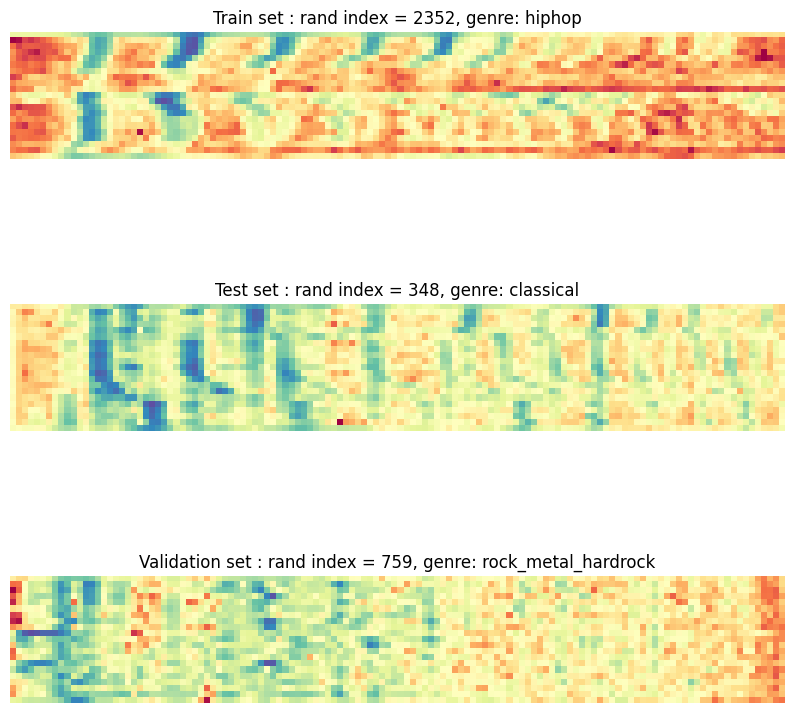

In [7]:
swap_genres_mapping = {genres_mapping[key]: key for key in genres_mapping}      # key-value swapping

# lab7
plt.figure(figsize=(10, 10))

sample_idx = torch.randint(len(train_set), size=(1,)).item()
img, label = train_set[sample_idx]
plt.subplot(3, 1, 1)
plt.title("Train set : rand index = "+ str(sample_idx)+ ", genre: " +str(swap_genres_mapping[label]))
plt.axis("off")
plt.imshow(img.squeeze(), cmap="Spectral")

sample_idx = torch.randint(len(test_set), size=(1,)).item()
img, label = test_set[sample_idx]
plt.subplot(3, 1, 2)
plt.title("Test set : rand index = "+ str(sample_idx)+ ", genre: " +str(swap_genres_mapping[label]))
plt.axis("off")
plt.imshow(img.squeeze(), cmap="Spectral")

sample_idx = torch.randint(len(val_set), size=(1,)).item()
img, label = val_set[sample_idx]
plt.subplot(3, 1, 3)
plt.title("Validation set : rand index = "+ str(sample_idx)+ ", genre: " +str(swap_genres_mapping[label]))
plt.axis("off")
plt.imshow(img.squeeze(), cmap="Spectral")

plt.show()

#### **Βήμα 2**: Ορισμός Νευρωνικού Δικτύου

https://colab.research.google.com/github/goodboychan/goodboychan.github.io/blob/main/_notebooks/2020-07-29-02-Using-Convolutional-Neural-Networks-in-PyTorch.ipynb#scrollTo=6eLhQh-lbim_

In [ ]:
# lab8 + ^^
class LeNet(nn.Module): ##Δανείζεται ιδέες από το leNet
  def __init__(self):
    super().__init__()

    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5)    #in_channels, out_channels, kernel_size, stride=1, padding=0)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv4 = nn.Conv2d(64, 128, 5)

    self.LinearStack = nn.Sequential(
      nn.Linear(71680, 1024),          # mat1 and mat2 shapes cannot be multiplied (16x71680 and 1024x1024)
      nn.Linear(1024, 256),
      nn.Linear(256, 32),
      nn.Linear(32, 4),
    )

  def forward(self, x):

    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)

    x = torch.flatten(x, 1)

    x = self.LinearStack(x)

    return x


$ $

#### **Βήμα 3**: Εκπαίδευση δικτύου

Ορισμός διαδικασίας εκπαίδευσης

In [9]:
def network_training(dataloader, model, loss_fn, optimizer, device, epoch):

  size = len(dataloader.dataset)

  # lab 7
  for batch, (X, y) in enumerate(dataloader):

    X = X.unsqueeze(1)

    # if using gpu dont forget to move the data there
    X = X.to(device)
    y = y.to(device)

    # Compute prediction and loss
    pred = model(X) ## For each input batch
    loss = loss_fn(pred, y) ##compute loss

    # Backpropagation
    optimizer.zero_grad()     ##find gradients
    loss.backward()     ##bacvk propagate loss
    optimizer.step()    ##optimization

    if batch % 10 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  return model

$ $

Ορισμός διαδικασίας αξιολόγησης

In [10]:
# lab7
def test_loop(dataloader, model, loss_fn):

    all_y = []
    all_preds = []
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():

        for X, y in dataloader:

            X = X.unsqueeze(1)

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            all_y.append(y.cpu())

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_preds.append(pred.cpu())

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    all_y = torch.cat( all_y )
    all_preds = torch.cat( all_preds )

    f1Score = f1_score( task="multiclass", preds = all_preds, target = all_y, num_classes= len(genres_mapping), average='macro' )
    confusion_matrix = ConfusionMatrix( task='multiclass', num_classes= len(genres_mapping) )
    confusion_matrix = confusion_matrix(all_preds, all_y)

    print(f"f1-score: {f1Score.item()}\n")
    print(f"The confusion matrix is:\n{confusion_matrix} \n")

    return test_loss, f1Score, 100*correct, confusion_matrix

$ $

Εκπαίδευση δικτύου

In [ ]:
# lab7
if torch.cuda.is_available():
  device="cuda"
else:
    device="cpu"

print ("device=",device)
net = LeNet().to(device)


# lab7
learning_rate = 0.002     # define the learning rate

optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)   # define the optimizer object

loss_fn = nn.CrossEntropyLoss()     # define the loss function

num_epochs = 30   # define number of epochs

best_epoch = 0
best_f1 = 0.0
best_model = net
for epoch in range(num_epochs):

    print(f"\n\n-- {epoch}. Epoch--\n")

    # Network training
    network_training(train_dataloader, net, loss_fn, optimizer, device, epoch)

    # Evaluation function
    loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, net, loss_fn)

    if f1_macro_avg >= best_f1:
      best_f1 = f1_macro_avg
      best_epoch = epoch
      best_model = net

print("Done!\n")

print(f"The best performance of the f1-score metric for validation set is {best_f1} at epoch no.{best_epoch}")
test_loop(val_dataloader, best_model, loss_fn)
print("Done!\n")

device= cuda


-- 0. Epoch--

loss: 1.393071  [    0/ 3200]
loss:     nan  [  160/ 3200]
loss:     nan  [  320/ 3200]
loss:     nan  [  480/ 3200]
loss:     nan  [  640/ 3200]
loss:     nan  [  800/ 3200]
loss:     nan  [  960/ 3200]
loss:     nan  [ 1120/ 3200]
loss:     nan  [ 1280/ 3200]
loss:     nan  [ 1440/ 3200]
loss:     nan  [ 1600/ 3200]
loss:     nan  [ 1760/ 3200]
loss:     nan  [ 1920/ 3200]
loss:     nan  [ 2080/ 3200]
loss:     nan  [ 2240/ 3200]
loss:     nan  [ 2400/ 3200]
loss:     nan  [ 2560/ 3200]
loss:     nan  [ 2720/ 3200]
loss:     nan  [ 2880/ 3200]
loss:     nan  [ 3040/ 3200]
Test Error: 
 Accuracy: 25.0%, Avg loss:      nan 

f1-score: 0.10000000149011612

The confusion matrix is:
tensor([[200,   0,   0,   0],
        [200,   0,   0,   0],
        [200,   0,   0,   0],
        [200,   0,   0,   0]]) 



-- 1. Epoch--

loss:     nan  [    0/ 3200]
loss:     nan  [  160/ 3200]
loss:     nan  [  320/ 3200]
loss:     nan  [  480/ 3200]
loss:     nan  [  640/ 32


Η πληροφορία που εξάγουμε αυτά τα αποτελέσματα και συγκεκριμένα από την πληροφορία της απώλειας (loss) είναι ότι το μοντέλο δεν μπορεί να εκπαιδευτεί. Παρατηρούμε ότι ήδη από την πρώτη  epoch, η τιμή της απώλειας αυξάνεται στο άπειρο. Αυτό σημαίνει ότι το δίκτυο έχει σοβαρό πρόβλημα, όπου το καθιστά μη ικανό να παράξει σωστά αποτελέσματα.


$ $

#### **Βήμα 4**: Pooling and padding

In [27]:
# lab8
class LeNet(nn.Module): ##Δανείζεται ιδέες από το leNet
  def __init__(self):
    super().__init__()

    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5, stride=1, padding=2)    #in_channels, out_channels, kernel_size, stride=1, padding=0)
    self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
    self.conv3 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
    self.conv4 = nn.Conv2d(64, 128, 5, stride=1, padding=2)

    self.dense1 = nn.Linear(1024, 1024)     #in_features, out_features)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size = 2, stride = 2)  ## import torch.nn.functional as F
      x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size = 2, stride = 2)  ##  input, kernel_size, stride=None, padding=0,
      x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size = 2, stride = 2)
      x = F.max_pool2d(F.relu(self.conv4(x)), kernel_size = 2, stride = 2)

      x = torch.flatten(x, 1)

      x = F.relu(self.dense1(x))
      x = F.relu(self.dense2(x))
      x = F.relu(self.dense3(x))
      x = self.dense4(x)

      return x

In [28]:
device = 'cpu'
net = LeNet().to(device)
print (f"device={device}")

# lab7
learning_rate = 0.002     # define the learning rate

optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)   # define the optimizer object

loss_fn = nn.CrossEntropyLoss()     # define the loss function

num_epochs = 30   # define number of epochs

best_epoch = 0
best_f1 = 0.0
best_model = net
for epoch in range(num_epochs):

    print(f"\n\n-- {epoch}. Epoch--\n")

    # Network training
    network_training(train_dataloader, net, loss_fn, optimizer, device, epoch)

    # Evaluation function
    loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, net, loss_fn)

    if f1_macro_avg >= best_f1:
      best_f1 = f1_macro_avg
      best_epoch = epoch
      best_model = net

print("Done!\n")

print(f"The best performance of the f1-score metric for validation set is {best_f1} at epoch no.{best_epoch}")
test_loop(val_dataloader, best_model, loss_fn)
print("Done!\n")

device=cpu


-- 0. Epoch--

loss: 1.391749  [    0/ 3200]
loss: 1.371433  [  160/ 3200]
loss: 1.372886  [  320/ 3200]
loss: 1.372379  [  480/ 3200]
loss: 1.392114  [  640/ 3200]
loss: 1.368801  [  800/ 3200]
loss: 1.384596  [  960/ 3200]
loss: 1.376432  [ 1120/ 3200]
loss: 1.373046  [ 1280/ 3200]
loss: 1.377460  [ 1440/ 3200]
loss: 1.378538  [ 1600/ 3200]
loss: 1.378729  [ 1760/ 3200]
loss: 1.385961  [ 1920/ 3200]
loss: 1.360923  [ 2080/ 3200]
loss: 1.369916  [ 2240/ 3200]
loss: 1.364937  [ 2400/ 3200]
loss: 1.378662  [ 2560/ 3200]
loss: 1.352140  [ 2720/ 3200]
loss: 1.390034  [ 2880/ 3200]
loss: 1.358244  [ 3040/ 3200]
Test Error: 
 Accuracy: 25.0%, Avg loss: 0.085830 

f1-score: 0.10000000149011612

The confusion matrix is:
tensor([[  0,   0, 200,   0],
        [  0,   0, 200,   0],
        [  0,   0, 200,   0],
        [  0,   0, 200,   0]]) 



-- 1. Epoch--

loss: 1.384206  [    0/ 3200]
loss: 1.348255  [  160/ 3200]
loss: 1.387290  [  320/ 3200]
loss: 1.384821  [  480/ 3200]
loss

* **max pooling**: βασικό χαρακτηριστικό του, είναι ότι μειώνει τις διαστάσεις των χαρακτηριστικών, επιλέγοντας από κάθε πυρήνα εκείνο το στοιχείο που έχει τη μέγιστη τιμή. Αυτό έχει ως αποτέλεσμα να διατηρούνται τα πιο σημαντικά χαρακτηριστικά. Επιπλέον μειώνει το υπολογιστικό κόστος κάνοντας το μοντέλο, πιο αποδοτικό και γρήγορο αποφεύγοντας το πρόβλημα της υπερπροσαμογής.






* **padding = 2**: με την αύξηση της παραμέτρου σε 2, γίνεται δυνατή η εισαγωγή μηδενικών τιμών στα δεδομένα μας, διατηρώντας έτσι, το μέγεθος των δεδομένων καθ’ όλη τη διάρκεια της επεξεργασίας τους, και λαμβάνοντας υπόψη και τις ακραίες τιμές. Με την προσθήκη της παραμέτρου η απόδοση του δικτύου βελτιώνεται.


*Παρατηρούμε* ότι η εκμάθηση και η εκτέλεση του δικτύου είναι πολύ γρήγορη με την ενσωμάτωση max φpooling και padding, επιτυγχάνοντας ακρίβεια 69,4%


$ $

#### **Βήμα 5**: Αλγόριθμοι βελτιστοποίησης

In [29]:
listOpts = ['Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'ASGD', 'NAdam', 'RAdam', 'RMSprop', 'Rprop', 'SGD']

device = 'cpu'
print (f"device={device}")

for opt in listOpts:

  print(f"----    {opt} Optimizer   ----")

  model = LeNet().to(device)

  # optimizer selection
  if opt == 'Adadelta': optimizer = torch.optim.Adadelta( model.parameters(), lr = learning_rate )
  elif opt == 'Adagrad': optimizer = torch.optim.Adagrad( model.parameters(), lr = learning_rate )
  elif opt == 'Adam': optimizer = torch.optim.Adam( model.parameters(), lr = learning_rate )
  elif opt == 'AdamW': optimizer = torch.optim.AdamW( model.parameters(), lr = learning_rate )
  elif opt == 'Adamax': optimizer = torch.optim.Adamax( model.parameters(), lr = learning_rate )
  elif opt == 'ASGD': optimizer = torch.optim.ASGD( model.parameters(), lr = learning_rate )
  elif opt == 'NAdam': optimizer = torch.optim.NAdam( model.parameters(), lr = learning_rate )
  elif opt == 'RAdam': optimizer = torch.optim.RAdam( model.parameters(), lr = learning_rate )
  elif opt == 'RMSprop': optimizer = torch.optim.RMSprop( model.parameters(), lr = learning_rate )
  elif opt == 'Rprop': optimizer = torch.optim.Rprop( model.parameters(), lr = learning_rate )
  elif opt == 'SGD': optimizer = torch.optim.SGD( model.parameters(), lr = learning_rate )

  best_epoch = 0
  best_f1 = 0.0
  best_model = model
  for epoch in range(num_epochs):

      print(f"\n\n-- {epoch}. Epoch--\n")

      # Network training
      network_training(train_dataloader, model, loss_fn, optimizer, device, epoch)

      # Evaluation function
      loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, model, loss_fn)

      if f1_macro_avg >= best_f1:
        best_f1 = f1_macro_avg
        best_epoch = epoch
        best_model = model

  print("Done!\n")

  print(f"The best performance of the f1-score metric for validation set is {best_f1} at epoch no.{best_epoch}")
  loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, best_model, loss_fn)
  print("Done!\n")

  print(f"-- Algorithm optimizer: {opt} ---")
  print(f"   Accuracy: {accuracy}  \t  f1_macro_avg: {f1_macro_avg} \n")


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.



-- 10. Epoch--

loss: 0.530160  [    0/ 3200]
loss: 0.443412  [  160/ 3200]
loss: 0.482823  [  320/ 3200]
loss: 0.191013  [  480/ 3200]
loss: 0.195802  [  640/ 3200]
loss: 0.576714  [  800/ 3200]
loss: 0.550736  [  960/ 3200]
loss: 0.351516  [ 1120/ 3200]
loss: 0.241617  [ 1280/ 3200]
loss: 0.688660  [ 1440/ 3200]
loss: 0.478891  [ 1600/ 3200]
loss: 0.269627  [ 1760/ 3200]
loss: 0.674066  [ 1920/ 3200]
loss: 0.295085  [ 2080/ 3200]
loss: 0.363329  [ 2240/ 3200]
loss: 0.248018  [ 2400/ 3200]
loss: 0.288095  [ 2560/ 3200]
loss: 0.675295  [ 2720/ 3200]
loss: 0.305539  [ 2880/ 3200]
loss: 0.510245  [ 3040/ 3200]
Test Error: 
 Accuracy: 67.1%, Avg loss: 0.061695 

f1-score: 0.6764494180679321

The confusion matrix is:
tensor([[132,  18,  31,  19],
        [ 53, 135,   1,  11],
        [ 27,   0, 159,  14],
        [ 61,   5,  23, 111]]) 



-- 11. Epoch--

loss: 0.237414  [    0/ 3200]
loss: 0.360666  [  160/ 3200]
loss: 0.273088  [ 

In [ ]:
df = pd.DataFrame({'Algorithm optimizer': [ 'Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'ASGD', 'NAdam', 'RAdam', 'RMSprop', 'Rprop', 'SGD'],
                   'Accuracy': ['55.625', '73.0', '61.875', '71.5', '73.125', '62.875', '66.5', '69.5', '72.25', '66.5', '61.625'],
                   'f1_macro_avg': ['0.5489675998687744', '0.7281878590583801', '0.6189059615135193', '0.7171111106872559',
                                    '0.7327306270599365', '0.6312339305877686', '0.655261754989624', '0.7012351751327515',
                                    '0.7225710153579712', '0.666827380657196', '0.6057555675506592']
                  })

df.set_index('Algorithm optimizer')


,Accuracy,f1_macro_avg
Algorithm optimizer,,
Adadelta,55.625,0.5489675998687744
Adagrad,73.0,0.7281878590583801
Adam,61.875,0.6189059615135193
AdamW,71.5,0.7171111106872559
Adamax,73.125,0.7327306270599365
ASGD,62.875,0.6312339305877686
NAdam,66.5,0.655261754989624
RAdam,69.5,0.7012351751327515
RMSprop,72.25,0.7225710153579712


Ο καλύτερος αλγόριθμος optimizer είναι ο Adamax με accuracy 73.125 και με f1-score 0.7327306270599365 . Παρατηρούμε ότι ο Adamax κατέχει τις μεγαλύτερες τιμές και στις 2 μετρικές σε σχέση με τις υπόλοιπες.
$ $

Μη αποδοτικός σε σχέση με τους υπόλοιπους εξετάσιμους αλγορίθμους είναι ο Adadelta.
$ $

Επίσης παρατηρούμε ότι και ο αλγόριθμος Adagrad είναι εξίσου καλός  με τον Adamax οι οποίοι έχουν πολύ μικρή διαφορά απόδοσης.
Τέλος παρατηρούμε ότι ο NAdam και ο Rprop έχουν την ίδια τιμή accuracy (66.5)


# Ερώτημα 3: Improving Performance - προαιρετικό ερώτημα

#### **Βήμα 1**: Reproducibility

Αρχικά κάνουμε “seed” όλες τις απαραίτητες βιβλιοθήκες και
αλγορίθμους.

In [2]:
def torch_seed(seed):
  torch.manual_seed(seed)
  random.seed(seed)

  np.random.seed(seed)
  torch.cuda.manual_seed_all(seed)

  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

$ $

Δοκιμάζουμε να τρέξουμε 2 φορές την ίδια ακριβώς διαδικασία εκπαίδευσης.

In [29]:
# -- test set --
X_test_melgrams = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/test/melgrams/X.npy')
Labels_test_melgrams = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/test/melgrams/labels.npy')

# -- training set --
X_train_melgrams = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/train/melgrams/X.npy')
Labels_train_melgrams = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/train/melgrams/labels.npy')

# -- validation set --
X_val_melgrams = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/val/melgrams/X.npy')
Labels_val_melgrams = np.load('/content/drive/MyDrive/Data_PatternRecognition-MachineLearning_2023/music_genre_data_di/val/melgrams/labels.npy')

In [30]:
# transformation of class names into integers from 0 to 3, while keeping the corresponding mapping in a dictionary

#  1. mapping creation
genres = np.unique( Labels_test_melgrams )
numbers = list( range(0,4) )
genres = zip(genres, numbers)
genres_mapping = dict( genres )

# 2. transformation
Numeric_Labels_test_melgrams = np.array( [ genres_mapping[label] for label in Labels_test_melgrams ] )
Numeric_Labels_train_melgrams = np.array( [ genres_mapping[label] for label in Labels_train_melgrams ] )
Numeric_Labels_val_melgrams = np.array( [ genres_mapping[label] for label in Labels_val_melgrams ] )

genres_mapping

{'blues': 0, 'classical': 1, 'hiphop': 2, 'rock_metal_hardrock': 3}

In [31]:
class MELGRAMS_Dataset:
  def __init__(self, data, labels):
        self.X = data
        self.labels = labels

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
        sound = self.X[index]
        genre = self.labels[index]

        return sound, genre

In [32]:
test_set = MELGRAMS_Dataset(X_test_melgrams, Numeric_Labels_test_melgrams)
train_set = MELGRAMS_Dataset(X_train_melgrams, Numeric_Labels_train_melgrams)
val_set = MELGRAMS_Dataset(X_val_melgrams, Numeric_Labels_val_melgrams)

In [33]:
# define the batch size for the dataloaders -->> lab7
batch_size = 16

test_dataloader= torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)
train_dataloader= torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_dataloader= torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)

$ $

Ορισμός Νευρωνικού Δικτύου

In [8]:
# lab8
class LeNet(nn.Module): ##Δανείζεται ιδέες από το leNet
  def __init__(self):
    super().__init__()

    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5, stride=1, padding=2)    #in_channels, out_channels, kernel_size, stride=1, padding=0)
    self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
    self.conv3 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
    self.conv4 = nn.Conv2d(64, 128, 5, stride=1, padding=2)

    self.dense1 = nn.Linear(1024, 1024)     #in_features, out_features)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size = 2, stride = 2)  ## import torch.nn.functional as F
      x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size = 2, stride = 2)  ##  input, kernel_size, stride=None, padding=0,
      x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size = 2, stride = 2)
      x = F.max_pool2d(F.relu(self.conv4(x)), kernel_size = 2, stride = 2)

      x = torch.flatten(x, 1)

      x = F.relu(self.dense1(x))
      x = F.relu(self.dense2(x))
      x = F.relu(self.dense3(x))
      x = self.dense4(x)

      return x

$ $

Ορισμός διαδικασίας εκπαίδευσης

In [35]:
def network_training(dataloader, model, loss_fn, optimizer, device, epoch, PRINT = False):

  size = len(dataloader.dataset)
  loss1 = 0

  # lab 7
  for batch, (X, y) in enumerate(dataloader):

    X = X.unsqueeze(1)

    # if using gpu dont forget to move the data there
    X = X.to(device)
    y = y.to(device)

    # Compute prediction and loss
    pred = model(X) ## For each input batch
    loss = loss_fn(pred, y) ##compute loss
    loss1 += loss

    # Backpropagation
    optimizer.zero_grad()     ##find gradients
    loss.backward()     ##bacvk propagate loss
    optimizer.step()    ##optimization

    if batch % 10 == 0:
      loss, current = loss.item(), batch * len(X)
      if PRINT: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    loss1 /= size

  return model, loss1

$ $

Ορισμός διαδικασίας αξιολόγησης

In [36]:
# lab7
def test_loop(dataloader, model, loss_fn):

    all_y = []
    all_preds = []
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():

        for X, y in dataloader:

            X = X.unsqueeze(1)

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            all_y.append(y.cpu())

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_preds.append(pred.cpu())

    test_loss /= size
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    all_y = torch.cat( all_y )
    all_preds = torch.cat( all_preds )

    f1Score = f1_score( task="multiclass", preds = all_preds, target = all_y, num_classes= len(genres_mapping), average='macro' )
    confusion_matrix = ConfusionMatrix( task='multiclass', num_classes= len(genres_mapping) )
    confusion_matrix = confusion_matrix(all_preds, all_y)

    print(f"f1-score: {f1Score.item()}\n")
    print(f"The confusion matrix is:\n{confusion_matrix} \n")

    return test_loss, f1Score, 100*correct, confusion_matrix

$ $

Εκπαίδευση δικτύου

In [28]:
device = 'cpu'
model = LeNet().to(device)
print (f"device={device}")

# lab7
learning_rate = 0.002     # define the learning rate

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)   # define the optimizer object

loss_fn = nn.CrossEntropyLoss()     # define the loss function

num_epochs = 30   # define number of epochs

best_epoch = 0
best_f1 = 0.0
best_model = model
for epoch in range(num_epochs):

  print(f"\n\n-- {epoch}. Epoch--\n")

  for i in range(2):

    if i == 0 : print("-- 1st -- iteration")
    if i == 1 : print("\n-- 2nd -- iteration")

    torch_seed(seed=0)

    model = LeNet().to(device)
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.002)

    # Network training
    network_training(train_dataloader, model, loss_fn, optimizer, device, epoch, PRINT = True)

    # Evaluation function
    loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, model, loss_fn)


  if f1_macro_avg >= best_f1:
    best_f1 = f1_macro_avg
    best_epoch = epoch
    best_model = model

print("Done!\n")

print(f"The best performance of the f1-score metric for validation set is {best_f1} at epoch no.{best_epoch}")
test_loop(val_dataloader, best_model, loss_fn)
print("Done!\n")



device=cpu


-- 0. Epoch--

-- 1st -- iteration
loss: 1.428793  [    0/ 3200]
loss: 1.409127  [  160/ 3200]
loss: 1.368810  [  320/ 3200]
loss: 1.417166  [  480/ 3200]
loss: 1.405719  [  640/ 3200]
loss: 1.381523  [  800/ 3200]
loss: 1.424026  [  960/ 3200]
loss: 1.384291  [ 1120/ 3200]
loss: 1.359442  [ 1280/ 3200]
loss: 1.380080  [ 1440/ 3200]
loss: 1.389945  [ 1600/ 3200]
loss: 1.380502  [ 1760/ 3200]
loss: 1.404013  [ 1920/ 3200]
loss: 1.364731  [ 2080/ 3200]
loss: 1.374340  [ 2240/ 3200]
loss: 1.399036  [ 2400/ 3200]
loss: 1.378124  [ 2560/ 3200]
loss: 1.380889  [ 2720/ 3200]
loss: 1.396634  [ 2880/ 3200]
loss: 1.376904  [ 3040/ 3200]
Test Error: 
 Accuracy: 27.0%, Avg loss: 0.086278 

f1-score: 0.18037648499011993

The confusion matrix is:
tensor([[103,  97,   0,   0],
        [ 86, 113,   1,   0],
        [186,  14,   0,   0],
        [ 36, 164,   0,   0]]) 


-- 2nd -- iteration
loss: 1.428793  [    0/ 3200]
loss: 1.409127  [  160/ 3200]
loss: 1.368810  [  320/ 3200]
loss: 1.41

$ $

#### **Βήμα 2**: Activation functions

In [13]:
# lab8
class LeNet2(nn.Module): ##Δανείζεται ιδέες από το leNet
  def __init__(self, function):
    super().__init__()

    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5, stride=1, padding=2)    #in_channels, out_channels, kernel_size, stride=1, padding=0)
    self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
    self.conv3 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
    self.conv4 = nn.Conv2d(64, 128, 5, stride=1, padding=2)

    self.fun = function()

    self.dense1 = nn.Linear(1024, 1024)     #in_features, out_features)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):

      x = F.max_pool2d(self.fun(F.relu(self.conv1(x))), kernel_size = 2, stride = 2)  ## import torch.nn.functional as F
      x = F.max_pool2d(self.fun(F.relu(self.conv2(x))), kernel_size = 2, stride = 2)  ##  input, kernel_size, stride=None, padding=0,
      x = F.max_pool2d(self.fun(F.relu(self.conv3(x))), kernel_size = 2, stride = 2)
      x = F.max_pool2d(self.fun(F.relu(self.conv4(x))), kernel_size = 2, stride = 2)

      x = torch.flatten(x, 1)

      x = self.fun(F.relu(self.dense1(x)))
      x = self.fun(F.relu(self.dense2(x)))
      x = self.fun(F.relu(self.dense3(x)))
      x = self.dense4(x)

      return x

In [15]:
listActivations = [
                    'ELU', 'Hardshrink', 'Hardsigmoid', 'Hardtanh', 'Hardswish', 'LeakyReLU',
                    'LogSigmoid', 'PReLU', 'SELU', 'Sigmoid', 'Tanh'
                  ]

device = 'cpu'
print (f"device={device}")

for act in listActivations:

  print(f"----    {act} Activation   ----")


  # optimizer selection
  if act == 'ELU': model = LeNet2(nn.ELU).to(device)
  elif act == 'Hardshrink': model = LeNet2(nn.Hardshrink).to(device)
  elif act == 'Hardsigmoid': model = LeNet2(nn.Hardsigmoid).to(device)
  elif act == 'Hardtanh': model = LeNet2(nn.Hardtanh).to(device)
  elif act == 'Hardswish': model = LeNet2(nn.Hardswish).to(device)
  elif act == 'LeakyReLU': model = LeNet2(nn.LeakyReLU).to(device)
  elif act == 'LogSigmoid': model = LeNet2(nn.LogSigmoid).to(device)
  elif act == 'PReLU': model = LeNet2(nn.PReLU).to(device)
  elif act == 'SELU': model = LeNet2(nn.SELU).to(device)
  elif act == 'Sigmoid': model = LeNet2(nn.Sigmoid).to(device)
  elif act == 'Tanh': model = LeNet2(nn.Tanh).to(device)

  learning_rate = 0.002     # define the learning rate

  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)   # define the optimizer object

  loss_fn = nn.CrossEntropyLoss()     # define the loss function

  num_epochs = 30   # define number of epochs

  best_epoch = 0
  best_f1 = 0.0
  best_model = model
  for epoch in range(num_epochs):

      print(f"\n\n-- {epoch}. Epoch--\n")

      # Network training
      network_training(train_dataloader, model, loss_fn, optimizer, device, epoch)

      # Evaluation function
      loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, model, loss_fn)

      if f1_macro_avg >= best_f1:
        best_f1 = f1_macro_avg
        best_epoch = epoch
        best_model = model

  print("Done!\n")

  print(f"The best performance of the f1-score metric for validation set is {best_f1} at epoch no.{best_epoch}")
  loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, best_model, loss_fn)
  print("Done!\n")

  print(f"-- {act} Activation ---")
  print(f"   Accuracy: {accuracy}  \t  f1_macro_avg: {f1_macro_avg} \n")


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Test Error: 
 Accuracy: 56.9%, Avg loss: 0.060563 

f1-score: 0.5609111189842224

The confusion matrix is:
tensor([[ 75,  57,  40,  28],
        [ 29, 161,   8,   2],
        [ 27,  13, 128,  32],
        [ 54,   9,  46,  91]]) 



-- 12. Epoch--

Test Error: 
 Accuracy: 56.6%, Avg loss: 0.061179 

f1-score: 0.5318871736526489

The confusion matrix is:
tensor([[ 40,  79,  58,  23],
        [  8, 176,  14,   2],
        [ 14,  16, 157,  13],
        [ 39,  15,  66,  80]]) 



-- 13. Epoch--

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.063495 

f1-score: 0.53205406665802

The confusion matrix is:
tensor([[ 72,  83,  14,  31],
        [ 23, 175,   0,   2],
        [ 57,  19,  81,  43],
        [ 69,  14,  13, 104]]) 



-- 14. Epoch--

Test Error: 
 Accuracy: 56.6%, Avg loss: 0.059363 

f1-score: 0.5455583930015564

The confusion matrix is:
tensor([[ 45,  61,  35,  59],
        [ 20, 166,  10,   4],
        [ 18,  13, 116,  53],
      

In [41]:
df = pd.DataFrame({'Activation functions': [ 'ELU', 'Hardshrink', 'Hardsigmoid', 'Hardtanh', 'Hardswish', 'LeakyReLU',
                          'LogSigmoid', 'PReLU', 'SELU', 'Sigmoid', 'Tanh'],
                   'Accuracy': ['65.5', '25.0', '25.0', '27.375', '76.875', '68.0', '25.0', '67.25', '70.125', '25.0', '25.1'],
                   'f1_macro_avg': ['0.657719075679779', '0.10000000149011612', '0.10000000149011612', '0.1535789519548416',
                                    '0.768426775932312', '0.673501193523407', '0.10000000149011612', '0.6584331393241882',
                                    '0.6967920660972595', '0.10000000149011612', '0.10258766263723373']
                  })

df.set_index('Activation functions')

,Accuracy,f1_macro_avg
Activation functions,,
ELU,65.5,0.657719075679779
Hardshrink,25.0,0.10000000149011612
Hardsigmoid,25.0,0.10000000149011612
Hardtanh,27.375,0.1535789519548416
Hardswish,76.875,0.768426775932312
LeakyReLU,68.0,0.673501193523407
LogSigmoid,25.0,0.10000000149011612
PReLU,67.25,0.6584331393241882
SELU,70.125,0.6967920660972595


$ $
#### **Βήμα 4**: Learning rate scheduler

In [ ]:
listSchedulers = [
                  'LambdaLR', 'MultiplicativeLR', 'StepLR', 'MultiStepLR', 'LinearLR',
                  'ExponentialLR', 'PolynomialLR', 'CosineAnnealingLR', 'CyclicLR'
                 ]


device = 'cpu'
print (f"device={device}")

for sch in listSchedulers:

  print(f"----    {sch} Scheduler   ----")

  learning_rate = 0.002     # define the learning rate

  model = LeNet2(nn.SELU).to(device)

  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)   # define the optimizer object

  # scheduler selection
  if sch == 'LambdaLR':
    lambdalr = lambda epoch: pow(0.05, epoch / 5)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambdalr, verbose=True)

  if sch == 'MultiplicativeLR':
    lmbda = lambda epoch: 0.95
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda = lmbda, verbose=True)

  if sch == 'StepLR':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1, verbose=True)

  if sch == 'MultiStepLR':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,25], gamma=0.1, verbose=True)

  if sch == 'LinearLR':
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, verbose=True)

  if sch == 'ExponentialLR':
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, verbose=True)

  if sch == 'PolynomialLR':
    scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=4, power=1.0, verbose=True)

  if sch == 'CosineAnnealingLR':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10, eta_min=0, last_epoch=- 1, verbose = True)

  if sch == 'CyclicLR':
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, verbose = True)



  loss_fn = nn.CrossEntropyLoss()     # define the loss function

  num_epochs = 30   # define number of epochs

  best_epoch = 0
  best_f1 = 0.0
  best_model = model
  for epoch in range(num_epochs):

      print(f"\n\n-- {epoch}. Epoch--\n")

      # Network training
      network_training(train_dataloader, model, loss_fn, optimizer, device, epoch)

      # Evaluation function
      loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, model, loss_fn)

      if f1_macro_avg >= best_f1:
        best_f1 = f1_macro_avg
        best_epoch = epoch
        best_model = model

      scheduler.step()

  print("Done!\n")

  print(f"The best performance of the f1-score metric for validation set is {best_f1} at epoch no.{best_epoch}")
  loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, best_model, loss_fn)
  print("Done!\n")

  print(f"   Accuracy: {accuracy}  \t  f1_macro_avg: {f1_macro_avg} \n")
  print("----------------------------\n")


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 0.931009  [    0/ 3200]
loss: 0.884752  [  160/ 3200]
loss: 0.903049  [  320/ 3200]
loss: 0.719886  [  480/ 3200]
loss: 1.036677  [  640/ 3200]
loss: 0.964757  [  800/ 3200]
loss: 1.085631  [  960/ 3200]
loss: 0.807003  [ 1120/ 3200]
loss: 0.805414  [ 1280/ 3200]
loss: 0.871107  [ 1440/ 3200]
loss: 0.935640  [ 1600/ 3200]
loss: 0.916731  [ 1760/ 3200]
loss: 0.667532  [ 1920/ 3200]
loss: 0.886155  [ 2080/ 3200]
loss: 0.653947  [ 2240/ 3200]
loss: 0.866671  [ 2400/ 3200]
loss: 1.029750  [ 2560/ 3200]
loss: 1.115259  [ 2720/ 3200]
loss: 1.541463  [ 2880/ 3200]
loss: 1.012635  [ 3040/ 3200]
Test Error: 
 Accuracy: 57.9%, Avg loss: 0.061276 

f1-score: 0.5718210935592651

The confusion matrix is:
tensor([[ 60,  23,  74,  43],
        [ 38, 140,  18,   4],
        [ 14,   0, 157,  29],
        [ 29,   2,  63, 106]]) 

Adjusting learning rate of group 0 to 2.0000e-03.


-- 15. Epoch--

loss: 0.791663  [    0/ 3200]
loss: 0.908482  [

$ $

#### **Βήμα 5**: Batch Normalization

In [12]:
# lab8
class LeNet5(nn.Module): ##Δανείζεται ιδέες από το leNet
  def __init__(self, function):
    super().__init__()

    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5, stride=1, padding=2)    #in_channels, out_channels, kernel_size, stride=1, padding=0)
    self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
    self.conv3 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
    self.conv4 = nn.Conv2d(64, 128, 5, stride=1, padding=2)

    self.bNrm1 = nn.BatchNorm2d(1)
    self.bNrm2 = nn.BatchNorm2d(16)
    self.bNrm3 = nn.BatchNorm2d(32)
    self.bNrm4 = nn.BatchNorm2d(64)

    self.fun = function()

    self.dense1 = nn.Linear(1024, 1024)     #in_features, out_features)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = self.bNrm1(x)
      x = F.max_pool2d(self.fun(F.relu(self.conv1(x))), kernel_size = 2, stride = 2)  ## import torch.nn.functional as F

      x = self.bNrm2(x)
      x = F.max_pool2d(self.fun(F.relu(self.conv2(x))), kernel_size = 2, stride = 2)  ##  input, kernel_size, stride=None, padding=0,

      x = self.bNrm3(x)
      x = F.max_pool2d(self.fun(F.relu(self.conv3(x))), kernel_size = 2, stride = 2)

      x = self.bNrm4(x)
      x = F.max_pool2d(self.fun(F.relu(self.conv4(x))), kernel_size = 2, stride = 2)


      x = torch.flatten(x, 1)

      x = self.fun(F.relu(self.dense1(x)))
      x = self.fun(F.relu(self.dense2(x)))
      x = self.fun(F.relu(self.dense3(x)))
      x = self.dense4(x)

      return x

In [13]:
device = 'cpu'
print (f"device={device}")

model = LeNet5(nn.SELU).to(device)

# lab7
learning_rate = 0.002     # define the learning rate

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)   # define the optimizer object

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, verbose=True)

loss_fn = nn.CrossEntropyLoss()     # define the loss function

num_epochs = 30   # define number of epochs

best_epoch = 0
best_f1 = 0.0
best_model = model
for epoch in range(num_epochs):

    print(f"\n\n-- {epoch}. Epoch--\n")


    # Network training
    network_training(train_dataloader, model, loss_fn, optimizer, device, epoch)

    # Evaluation function
    loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, model, loss_fn)

    if f1_macro_avg >= best_f1:
      best_f1 = f1_macro_avg
      best_epoch = epoch
      best_accuracy = accuracy
      best_model = model

    scheduler.step()

print("Done!\n")

print(f"The best performance of the f1-score metric for validation set is {best_f1} at epoch no.{best_epoch}")
test_loop(val_dataloader, best_model, loss_fn)
print("Done!\n")

device=cpu
Adjusting learning rate of group 0 to 6.6667e-04.


-- 0. Epoch--

loss: 1.385980  [    0/ 3200]
loss: 1.382984  [  160/ 3200]
loss: 1.394410  [  320/ 3200]
loss: 1.386863  [  480/ 3200]
loss: 1.384830  [  640/ 3200]
loss: 1.389188  [  800/ 3200]
loss: 1.377817  [  960/ 3200]
loss: 1.383669  [ 1120/ 3200]
loss: 1.390736  [ 1280/ 3200]
loss: 1.388629  [ 1440/ 3200]
loss: 1.388943  [ 1600/ 3200]
loss: 1.390547  [ 1760/ 3200]
loss: 1.391686  [ 1920/ 3200]
loss: 1.384746  [ 2080/ 3200]
loss: 1.378397  [ 2240/ 3200]
loss: 1.384386  [ 2400/ 3200]
loss: 1.386570  [ 2560/ 3200]
loss: 1.389163  [ 2720/ 3200]
loss: 1.382841  [ 2880/ 3200]
loss: 1.384098  [ 3040/ 3200]
Test Error: 
 Accuracy: 25.0%, Avg loss: 0.086494 

f1-score: 0.10000000149011612

The confusion matrix is:
tensor([[  0,   0,   0, 200],
        [  0,   0,   0, 200],
        [  0,   0,   0, 200],
        [  0,   0,   0, 200]]) 

Adjusting learning rate of group 0 to 9.3333e-04.


-- 1. Epoch--

loss: 1.390939  [    0/ 

$ $

#### **Βήμα 6**: Regularization

In [34]:
# lab8
class LeNet6(nn.Module): ##Δανείζεται ιδέες από το leNet
  def __init__(self, function):
    super().__init__()

    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5, stride=1, padding=2)    #in_channels, out_channels, kernel_size, stride=1, padding=0)
    self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
    self.conv3 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
    self.conv4 = nn.Conv2d(64, 128, 5, stride=1, padding=2)

    self.bNrm1 = nn.BatchNorm2d(1)
    self.bNrm2 = nn.BatchNorm2d(16)
    self.bNrm3 = nn.BatchNorm2d(32)
    self.bNrm4 = nn.BatchNorm2d(64)

    self.fun = function()

    self.dropout = nn.Dropout(0.25)

    self.dense1 = nn.Linear(1024, 1024)     #in_features, out_features)
    self.dense2 = nn.Linear(1024, 256)
    self.dense3 = nn.Linear(256, 32)
    self.dense4 = nn.Linear(32, 4)

  def forward(self, x):
      x = self.bNrm1(x)
      x = F.max_pool2d(self.fun(F.relu(self.conv1(x))), kernel_size = 2, stride = 2)  ## import torch.nn.functional as F

      x = self.bNrm2(x)
      x = F.max_pool2d(self.fun(F.relu(self.conv2(x))), kernel_size = 2, stride = 2)  ##  input, kernel_size, stride=None, padding=0,

      x = self.bNrm3(x)
      x = F.max_pool2d(self.fun(F.relu(self.conv3(x))), kernel_size = 2, stride = 2)

      x = self.bNrm4(x)
      x = F.max_pool2d(self.fun(F.relu(self.conv4(x))), kernel_size = 2, stride = 2)


      x = torch.flatten(x, 1)

      x = self.dropout(x)
      x = self.fun(F.relu(self.dense1(x)))

      x = self.dropout(x)
      x = self.fun(F.relu(self.dense2(x)))

      x = self.dropout(x)
      x = self.fun(F.relu(self.dense3(x)))

      x = self.dropout(x)
      x = self.dense4(x)

      return x


In [44]:
def train_test_network(num_epochs, train_dataloader, val_dataloader, net, optimizer, device, scheduler):

  loss_fn = nn.CrossEntropyLoss()     # define the loss function

  best_epoch = 0
  best_f1 = 0.0
  best_model = net
  for epoch in range(num_epochs):

    print(f"\n\n-- {epoch}. Epoch --\n")

    # Network training
    _, loss1 = network_training(train_dataloader, net, loss_fn, optimizer, device, epoch)


    # Evaluation function
    loss2, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, net, loss_fn)

    if f1_macro_avg >= best_f1:
      best_f1 = f1_macro_avg
      best_epoch = epoch
      best_model = net

    scheduler.step()

  print("Done!\n")

  print(f"The best performance of the f1-score metric for validation set is {best_f1} at epoch no.{best_epoch}")
  test_loop(val_dataloader, best_model, loss_fn)
  print("Done!\n")

  # Calculating the difference between the train loss and the validation loss
  loss = loss1 - loss2

  print(f"-- The difference between the train loss and the validation loss is: {abs(loss)}")

In [45]:
def Regularization(WEIGHTDECAY, DROPOUT):

  device = 'cpu'
  print (f"device={device}")

  # -- DROPOUT --
  if DROPOUT: net = LeNet6(nn.SELU).to(device)
  else:
    net = LeNet5(nn.SELU).to(device)

  learning_rate = 0.002     # define the learning rate

  # -- WEIGHTDECAY --
  if WEIGHTDECAY: optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate, weight_decay = 0.00001)   # define the optimizer object
  else:
    optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)

  scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, verbose=True)

  for num_epochs in [30, 60]:
    print("--------------------------------------\n")
    print(f"\t-- Num Epochs = {num_epochs} --\n")
    print("--------------------------------------")
    train_test_network(num_epochs, train_dataloader, val_dataloader, net, optimizer, device, scheduler)


$ $

*  $\ \ $ **i.** $ \ $ weight_decay στον optimizer

In [46]:
print("Test Value: -wight_decay-")
Regularization(WEIGHTDECAY = True, DROPOUT = False)

Test Value: -wight_decay-
device=cpu
Adjusting learning rate of group 0 to 6.6667e-04.
--------------------------------------

	-- Num Epochs = 30 --

--------------------------------------


-- 0. Epoch --

Test Error: 
 Accuracy: 25.0%, Avg loss: 0.086821 

f1-score: 0.10000000149011612

The confusion matrix is:
tensor([[200,   0,   0,   0],
        [200,   0,   0,   0],
        [200,   0,   0,   0],
        [200,   0,   0,   0]]) 

Adjusting learning rate of group 0 to 9.3333e-04.


-- 1. Epoch --

Test Error: 
 Accuracy: 25.0%, Avg loss: 0.086418 

f1-score: 0.10000000149011612

The confusion matrix is:
tensor([[200,   0,   0,   0],
        [200,   0,   0,   0],
        [200,   0,   0,   0],
        [200,   0,   0,   0]]) 

Adjusting learning rate of group 0 to 1.2000e-03.


-- 2. Epoch --

Test Error: 
 Accuracy: 25.0%, Avg loss: 0.085743 

f1-score: 0.10000000149011612

The confusion matrix is:
tensor([[200,   0,   0,   0],
        [200,   0,   0,   0],
        [200,   0,   0,   

$ $

* $\ \ $ **ii.** $ \ $ dropout στα linear layers

In [47]:
print("Test Value: -DROPOUT-")
Regularization(WEIGHTDECAY = False, DROPOUT = True)

Test Value: -DROPOUT-
device=cpu
Adjusting learning rate of group 0 to 6.6667e-04.
--------------------------------------

	-- Num Epochs = 30 --

--------------------------------------


-- 0. Epoch --

Test Error: 
 Accuracy: 27.9%, Avg loss: 0.086503 

f1-score: 0.19908499717712402

The confusion matrix is:
tensor([[  8, 144,  47,   1],
        [  7, 139,  54,   0],
        [  6, 118,  76,   0],
        [  5, 135,  60,   0]]) 

Adjusting learning rate of group 0 to 9.3333e-04.


-- 1. Epoch --

Test Error: 
 Accuracy: 27.8%, Avg loss: 0.086432 

f1-score: 0.2043076604604721

The confusion matrix is:
tensor([[ 10, 139,  49,   2],
        [ 14, 144,  42,   0],
        [ 15, 119,  65,   1],
        [ 11, 126,  60,   3]]) 

Adjusting learning rate of group 0 to 1.2000e-03.


-- 2. Epoch --

Test Error: 
 Accuracy: 30.2%, Avg loss: 0.086170 

f1-score: 0.24662083387374878

The confusion matrix is:
tensor([[ 16, 123,  58,   3],
        [ 17, 136,  42,   5],
        [ 14, 107,  78,   1],
 

$ $

* $\ \ $ **i.** $ \ $ **+** $ \ $ **ii.** $ \ $ weight_decay στον optimizer $ \ $ + $ \ $ dropout στα linear layers

In [48]:
print("Test Value: wight_decay -and- DROPOUT")
Regularization(WEIGHTDECAY = True, DROPOUT = True)

Test Value: wight_decay -and- DROPOUT
device=cpu
Adjusting learning rate of group 0 to 6.6667e-04.
--------------------------------------

	-- Num Epochs = 30 --

--------------------------------------


-- 0. Epoch --

Test Error: 
 Accuracy: 28.4%, Avg loss: 0.086435 

f1-score: 0.2594698667526245

The confusion matrix is:
tensor([[ 48,  58,   3,  91],
        [ 41,  64,   4,  91],
        [ 42,  55,  15,  88],
        [ 42,  55,   3, 100]]) 

Adjusting learning rate of group 0 to 9.3333e-04.


-- 1. Epoch --

Test Error: 
 Accuracy: 31.4%, Avg loss: 0.086216 

f1-score: 0.28094324469566345

The confusion matrix is:
tensor([[ 62,  50,   7,  81],
        [ 49,  51,  11,  89],
        [ 59,  55,  14,  72],
        [ 24,  50,   2, 124]]) 

Adjusting learning rate of group 0 to 1.2000e-03.


-- 2. Epoch --

Test Error: 
 Accuracy: 33.0%, Avg loss: 0.085979 

f1-score: 0.30798768997192383

The confusion matrix is:
tensor([[ 56,  48,  10,  86],
        [ 60,  51,  10,  79],
        [ 63,  

In [14]:
df = pd.DataFrame({'Accuracy': ['30 epochs', '60 epochs'],
                   'wight_decay': ['77.2', '76.9'],
                   'dropout': ['78.0', '76.9'],
                   'wight_decay+dropout': ['71.6', '76.1']
                  })

df.set_index('Accuracy')

,wight_decay,dropout,wight_decay+dropout
Accuracy,,,
30 epochs,77.2,78.0,71.6
60 epochs,76.9,76.9,76.1


$ $

#### **Βήμα 7**: Training efficiency

* $ \ \ $ Batch size

In [49]:
def train_test_network_7(train_dataloader, val_dataloader, batch_size):

  device = 'cpu'
  print (f"device={device}")

  model = LeNet6(nn.SELU).to(device)

  # lab7
  learning_rate = 0.002     # define the learning rate

  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)   # define the optimizer object

  scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, verbose=True)

  loss_fn = nn.CrossEntropyLoss()     # define the loss function

  num_epochs = 30   # define number of epochs

  best_epoch = 0
  best_f1 = 0.0
  best_model = model
  for epoch in range(num_epochs):

      print(f"\n\n-- {epoch}. Epoch--\n")

      # Network training
      network_training(train_dataloader, model, loss_fn, optimizer, device, epoch)

      # Evaluation function
      loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, model, loss_fn)

      if f1_macro_avg >= best_f1:
        best_f1 = f1_macro_avg
        best_epoch = epoch
        best_model = model

      scheduler.step()

  print("Done!\n")

  print(f"The best performance of the f1-score metric for validation set is {best_f1} at epoch no.{best_epoch}")
  test_loop(val_dataloader, best_model, loss_fn)
  print("Done!\n")

επιλογή batch_size


In [50]:
# define the batch size for the dataloaders -->> lab7

for batch_size in [2, 4, 8, 16, 32, 64, 128]:

  print(f"\n---  batch_size = {batch_size}  ---\n")

  test_dataloader= torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)
  train_dataloader= torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
  val_dataloader= torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)

  start = time.time()

  train_test_network_7(train_dataloader, val_dataloader, batch_size)

  end = time.time()

  # batch_size: total time
  total_time_batch = end - start

  print(f"- batch_size_{batch_size}: total time = {total_time_batch} s")



---  batch_size = 2  ---

device=cpu
Adjusting learning rate of group 0 to 6.6667e-04.


-- 0. Epoch--

Test Error: 
 Accuracy: 30.5%, Avg loss: 0.689935 

f1-score: 0.24524879455566406

The confusion matrix is:
tensor([[ 29, 138,   0,  33],
        [ 33, 141,   1,  25],
        [ 42, 123,   0,  35],
        [ 31,  95,   0,  74]]) 

Adjusting learning rate of group 0 to 9.3333e-04.


-- 1. Epoch--

Test Error: 
 Accuracy: 41.4%, Avg loss: 0.676909 

f1-score: 0.3729479908943176

The confusion matrix is:
tensor([[ 31,  99,  11,  59],
        [ 29, 118,   6,  47],
        [ 45,  84,  31,  40],
        [ 14,  32,   3, 151]]) 

Adjusting learning rate of group 0 to 1.2000e-03.


-- 2. Epoch--

Test Error: 
 Accuracy: 50.7%, Avg loss: 0.594235 

f1-score: 0.48885685205459595

The confusion matrix is:
tensor([[ 41,  44,  41,  74],
        [ 37, 109,  24,  30],
        [ 28,   6,  94,  72],
        [ 14,   3,  21, 162]]) 

Adjusting learning rate of group 0 to 1.4667e-03.


-- 3. Epoch--

Te

In [ ]:
df = pd.DataFrame({' ': ['accuracy', 'f1-score', 'time (sec)'],
                   '2': ['80.4', '0.8013643026351929', '1003.0268206596375'],
                   '4': ['73.9', '0.7314172387123108', '752.9228870868683' ],
                   '8': ['74.4', '0.7447818517684937', '632.6741011142731'],
                   '16': ['75.9', '0.754814863204956', '563.6048707962036'],
                   '32': ['70.0', '0.6926971673965454', '532.2714831829071'],
                   '64': ['48.6', '0.4105285406112671', '514.1080942153931'],
                   '128': ['40.9', '0.35066235065460205', '513.0439174175262']
                  })

df.set_index(' ')

,2,4,8,16,32,64,128
,,,,,,,
accuracy,80.4,73.9,74.4,75.9,70.0,48.6,40.9
f1-score,0.8013643026351929,0.7314172387123108,0.7447818517684937,0.754814863204956,0.6926971673965454,0.4105285406112671,0.35066235065460205
time (sec),1003.0268206596375,752.9228870868683,632.6741011142731,563.6048707962036,532.2714831829071,514.1080942153931,513.0439174175262


Παρατηρούμε ότι καθώς αυξάνεται το μέγεθος του batch, η ακρίβεια και ο χρόνος μειώνονται (δηλαδή το μοντέλο εκπαιδεύεται πιο γρήγορα). Μπορεί να θέλουμε να εκπαιδεύεται γρήγορα το μοντέλο μας, άλλη η χαμηλή τιμή ακρίβειας (accuracy) έχει σαν συνέπεια το μοντέλο να αποτυγχάνει στη γενίκευση, καθώς παρουσιάζεται το πρόβλημα του overfitting.

$ $

* $ \ \ $ ***Early stopping***

In [ ]:
# lab7

device = 'cpu'
print (f"device={device}")

net = LeNet6(nn.SELU).to(device)

learning_rate = 0.002     # define the learning rate

optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)   # define the optimizer object

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, verbose=True)

loss_fn = nn.CrossEntropyLoss()     # define the loss function

num_epochs = 30   # define number of epochs

for patience in [2, 4, 6, 8, 10]:

  print(f"\n---  patience = {patience}  ---\n")

  best_epoch = 0
  best_f1 = 0.0
  best_model = net
  counter = 0

  start = time.time()

  for epoch in range(num_epochs):

    print(f"\n\n-- {epoch}. Epoch--\n")

    # Network training
    network_training(train_dataloader, net, loss_fn, optimizer, device, epoch)

    # Evaluation function
    loss, f1_macro_avg, accuracy, confusion_matrix = test_loop(val_dataloader, net, loss_fn)

    counter += 1

    if f1_macro_avg >= best_f1:
      best_f1 = f1_macro_avg
      best_epoch = epoch
      best_model = net
      counter = 0

    scheduler.step()

    if counter == patience :
      end = time.time()
      total_time = end - start
      print(f"The training and testing of epochs is completed in the epoch with increasing number {epoch} and with execution time: {total_time} s")
      break

  print("Done!\n")

  print(f"The best performance of the f1-score metric for validation set is {best_f1} and Accuracy is {accuracy} at epoch no.{best_epoch}")
  test_loop(val_dataloader, best_model, loss_fn)
  print("Done!\n")

device=cpu
Adjusting learning rate of group 0 to 6.6667e-04.

---  patience = 2  ---



-- 0. Epoch--

Test Error: 
 Accuracy: 24.2%, Avg loss: 0.086544 

f1-score: 0.12752051651477814

The confusion matrix is:
tensor([[  7, 190,   0,   3],
        [  8, 180,   3,   9],
        [  8, 179,   6,   7],
        [  7, 191,   1,   1]]) 

Adjusting learning rate of group 0 to 9.3333e-04.


-- 1. Epoch--

Test Error: 
 Accuracy: 25.4%, Avg loss: 0.086440 

f1-score: 0.14838795363903046

The confusion matrix is:
tensor([[  8, 185,   5,   2],
        [  9, 180,   6,   5],
        [ 14, 173,   8,   5],
        [  5, 188,   0,   7]]) 

Adjusting learning rate of group 0 to 1.2000e-03.


-- 2. Epoch--

Test Error: 
 Accuracy: 25.9%, Avg loss: 0.086359 

f1-score: 0.17000170052051544

The confusion matrix is:
tensor([[ 10, 178,   3,   9],
        [ 14, 173,   4,   9],
        [ 23, 147,  17,  13],
        [  8, 181,   4,   7]]) 

Adjusting learning rate of group 0 to 1.4667e-03.


-- 3. Epoch--

Tes

In [42]:
df = pd.DataFrame({' ': ['accuracy', 'time (sec)', 'epoch'],
                   '2': ['52.5', '129.5919108390808', '8'],
                   '4': ['78.2', '413.62428045272827', '22 ' ],
                   '6': ['78.0', '382.027663230896', '25'],
                   '8': ['78.5', '231.51818203926086', '15'],
                   '10': ['77.2', '295.0667781829834', '19']
                  })

df.set_index(' ')

,2,4,6,8,10
,,,,,
accuracy,52.5,78.2,78.0,78.5,77.2
time (sec),129.5919108390808,413.62428045272827,382.027663230896,231.51818203926086,295.0667781829834
epoch,8,22,25,15,19


Παρατηρούμε ότι όσο αυξάνεται το patience τόσο ο χρόνος και η τιμή ακρίβειας αυξάνονται.

$ $

# Ερώτημα 4: Testing – προαιρετικό ερώτημα

#### **Βήμα 1**: Inference

In [17]:
# lab7
def predictions(dataloader, model, device):

  all_preds = []

  # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
  with torch.no_grad():

    for X, y in dataloader:

      X = X.unsqueeze(1)

      # if using gpu dont forget to move the data there
      X = X.to(device)
      y = y.to(device)

      pred = model(X)

      p = pred.max(1)[1]
      p = p.item()
      all_preds.append(p)

  return all_preds

$ $

#### **Βήμα 2**: Κατέβασμα μουσικής


Εγκατάσταση του youtube-dl στο colab χρησιμοποιώντας την παρακάτω ακολουθία εντολών:

In [18]:
!sudo apt-get update
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl

%pip install --upgrade --force-reinstall "git+https://github.com/ytdl-org/youtube-dl.git"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [82.8 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal InRelease
Get:9 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,863 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:14 http://securi

In [19]:
window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21


def download_youtube(url):
    command = f'youtube-dl --extract-audio --audio-format wav --output temp.wav --postprocessor-args "-ar 8000" ' + url + " --quiet"
    os.system(command)


def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url):
    download_youtube(url)
    melgrams = get_melgrams("temp.wav")
    np.save("youtube_melgrams.npy", melgrams)


In [20]:
# -- classical music --

classical = { "https://www.youtube.com/watch?v=9E6b3swbnWg" : "Chopin - Nocturne op.9 No.2",
              "https://www.youtube.com/watch?v=7AKHjqyxpvw" : "Swan Lake",
              "https://www.youtube.com/watch?v=bBsKplb2E6Q" : "Prokofiev - Dance of the Knights",
              "https://www.youtube.com/watch?v=NqAOGduIFbg" : "Antonio Vivaldi - Storm"
            }


In [21]:
# -- pop music --

pop = { "https://www.youtube.com/watch?v=EDwb9jOVRtU" : "Madonna - Hung Up",
        "https://www.youtube.com/watch?v=JGwWNGJdvx8" : "Ed Sheeran - Shape of You",
        "https://www.youtube.com/watch?v=LsoLEjrDogU" : "Bruno Mars - Finesse (Remix) (feat. Cardi B)",
        "https://www.youtube.com/watch?v=dsUXAEzaC3Q" : "Michael Jackson - Bad"
      }


In [22]:
# -- rock music --

rock = {  "https://www.youtube.com/watch?v=OMaycNcPsHI" : "Placebo - Every You Every Me",
          "https://www.youtube.com/watch?v=dMbsju-qSeE" : "1000mods - Electric Carve",
          "https://www.youtube.com/watch?v=W1PNvopXjbg" : "Deep Purple - Hush",
          "https://www.youtube.com/watch?v=42rmUlDiQDI" : "Dirty Honey - Rolling 7s"
       }


In [27]:
# -- blues music --

blues = { "https://www.youtube.com/watch?v=l45f28PzfCI" : "BB King:How Blue Can You Get",
          "https://www.youtube.com/watch?v=EjDjq_ToixI" : "Blue Jean Blues",
          "https://www.youtube.com/watch?v=O8hqGu-leFc" : "Sweet Home Chicago",
          "https://www.youtube.com/watch?v=VAPDJheC0Jk" : "T Bone Walker stormy monday"
        }


$ $

#### **Βήμα 3**: Προβλέψεις

In [23]:
def MELDataset(label):

  melgrams =  np.load('youtube_melgrams.npy')

  labels = [label for i in range(len(melgrams))]
  labels = np.array(labels)
  melset = MELGRAMS_Dataset(melgrams, labels)

  # # define the batch size for the dataloaders -->> lab7
  batch_size = 1

  dataloader = torch.utils.data.DataLoader(melset, batch_size = batch_size, shuffle = False)

  device ='cpu'

  model = LeNet6(nn.SELU).to(device)

  loss_fn = nn.CrossEntropyLoss()     # define the loss function

  optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)

  network_training(train_dataloader, model, loss_fn, optimizer, device, epoch)

  return dataloader, model,  device

In [38]:
genres = {0:'blues', 1:'classical', 2:'hiphop', 3:'rock_metal_hardrock'}

$ $

***-- blues music --***

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


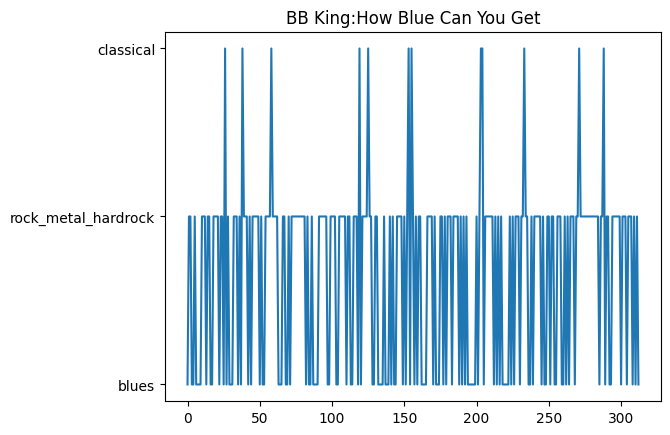

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


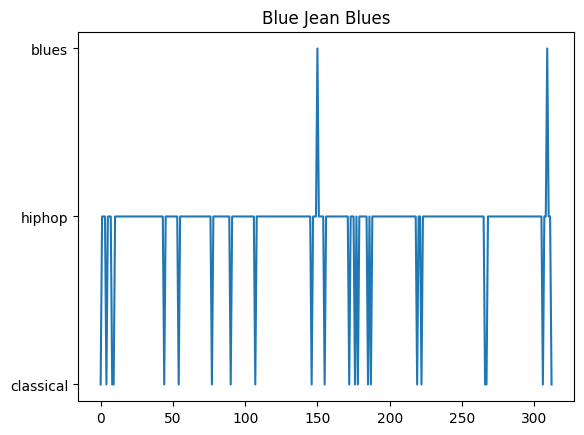

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


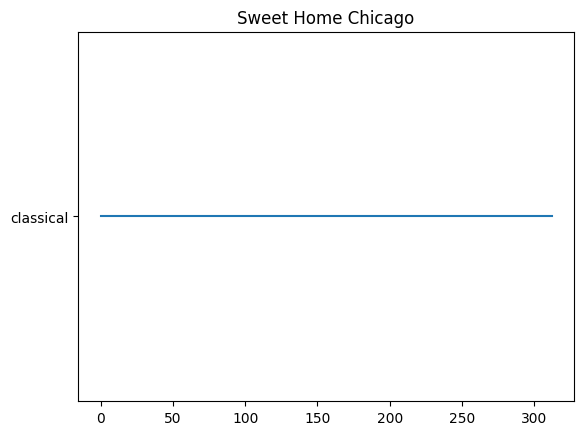

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


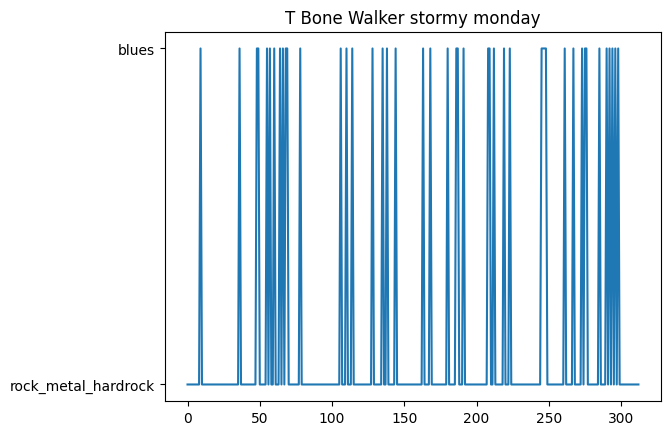

In [43]:
for b_song in blues:

  youtube_to_melgram(b_song)

  dataloader, model, device = MELDataset(0)

  preds = predictions(dataloader, model, device)
  preds = [genres[i] for i in preds]

  plt.plot(preds)
  plt.title(blues[b_song])
  plt.show()

$ $

***-- classical music --***

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


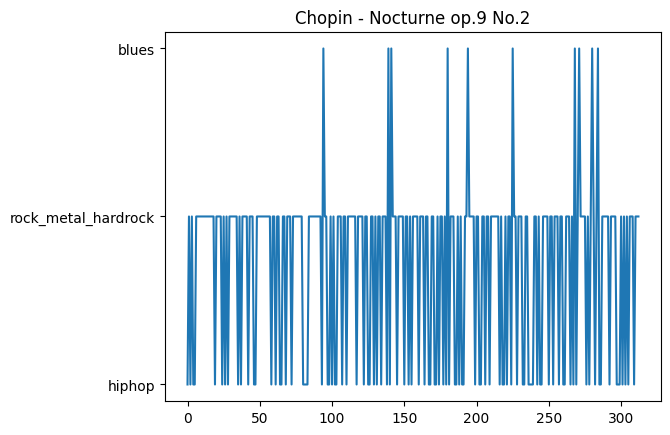

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


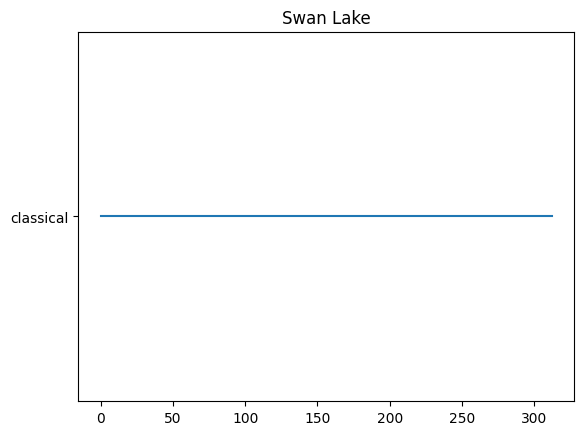

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


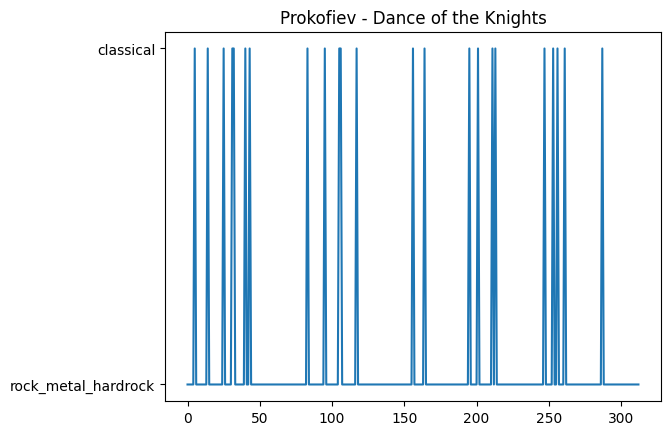

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


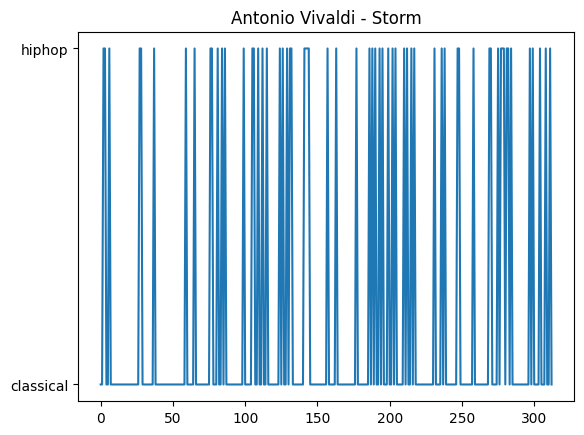

In [50]:
for c_song in classical:

  youtube_to_melgram(c_song)

  dataloader, model, device = MELDataset(0)

  preds = predictions(dataloader, model, device)
  preds = [genres[i] for i in preds]

  plt.plot(preds)
  plt.title(classical[c_song])
  plt.show()

$ $

***-- pop music --***

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


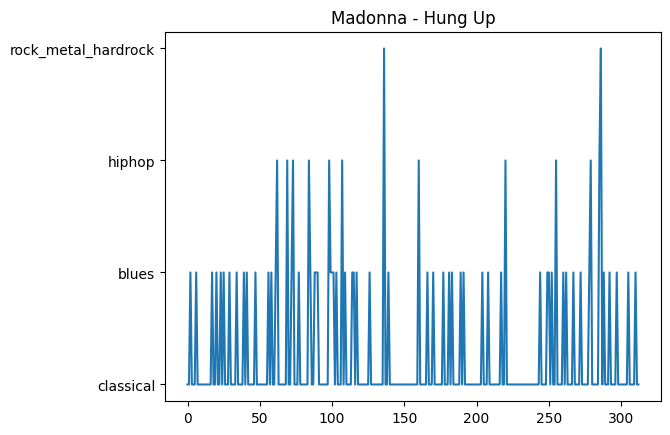

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


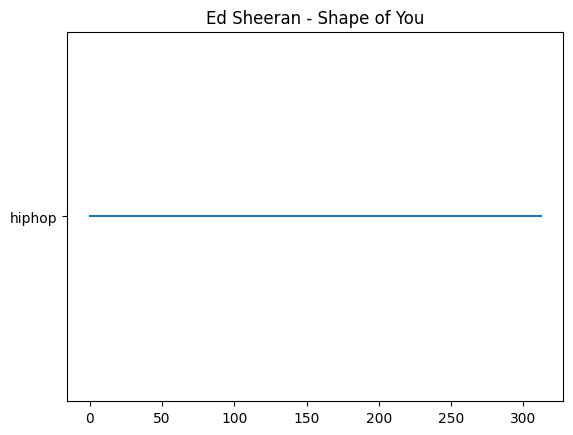

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


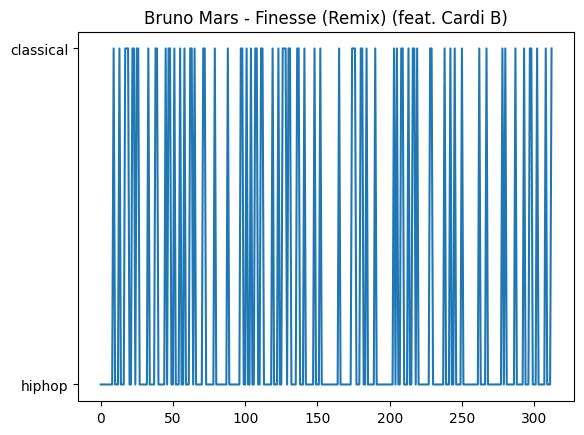

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


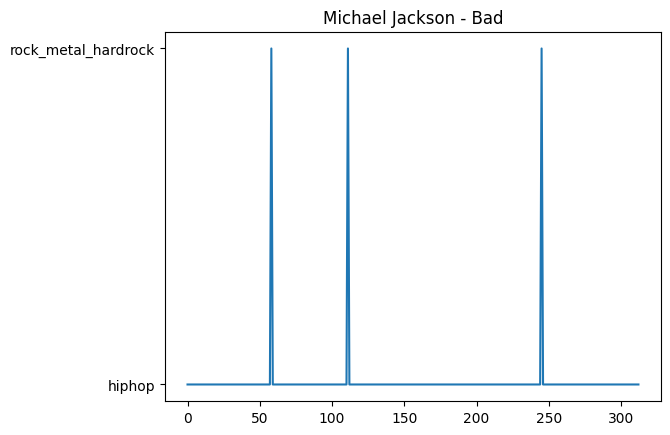

In [45]:
for p_song in pop:

  youtube_to_melgram(p_song)

  dataloader, model, device = MELDataset(0)

  preds = predictions(dataloader, model, device)
  preds = [genres[i] for i in preds]

  plt.plot(preds)
  plt.title(pop[p_song])
  plt.show()

$ $

***-- rock music --***

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


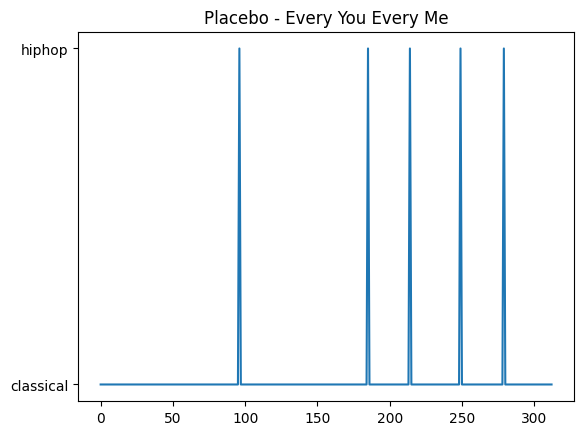

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


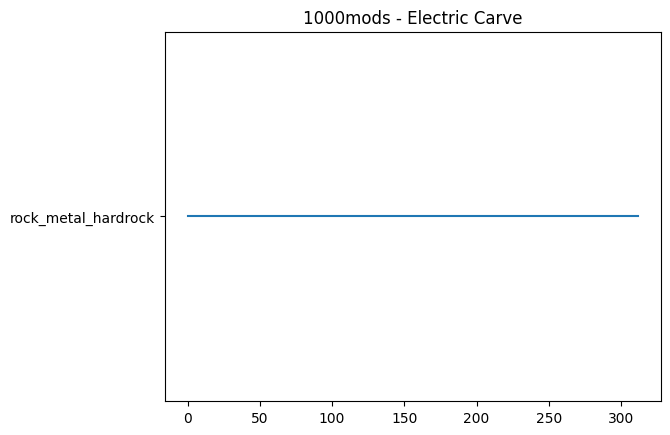

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


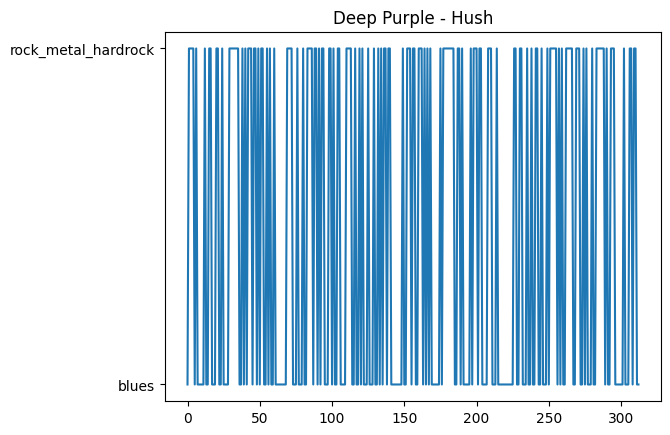

<ipython-input-19-23a354aa1131>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load(filename, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


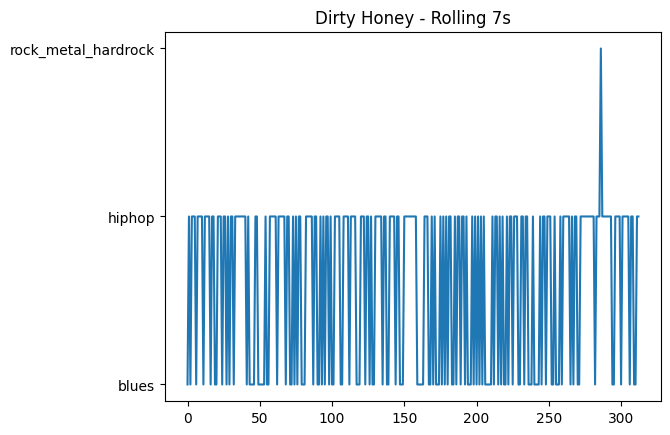

In [47]:
for r_song in rock:

  youtube_to_melgram(r_song)

  dataloader, model, device = MELDataset(0)

  preds = predictions(dataloader, model, device)
  preds = [genres[i] for i in preds]

  plt.plot(preds)
  plt.title(rock[r_song])
  plt.show()

Σε κάθε είδος μουσικής έχουν ανατεθεί 4 κομμάτια αυτού του είδους. Παρατηρούμε ότι ο ταξινομητής

$ $

* στη  **blues** μουσική αναγνώρισε 3 κομμάτια
* στη **κλασική** μουσική αναγνώριαε 3 κομμάτια
* στη **pop** αναγνώριαε και τα 4 κομμάτια
* και στην **ροκ** μουσική αναγνώρισε 3 κομμάτια

Παρατηρούμε ότι ο ταξινομητής βρήκε σχεδόν όλα τα κομμάτια κάθε είδους.
Στη ποπ μουσική ο ταξινομητής κατάφερε και βρήκε και τα 4 κομμάτια!
